## Setup

In [1]:
# Loading packages and their components
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Matplotlib configuration
plt.rcParams['figure.figsize'] = [15, 7]

## Helper functions

In [3]:
def rem_col(df, col):
    '''
    Removes columns from a dataframe that contain a string.
    '''
    return df.loc[:,~df.columns.str.contains(col)]

In [4]:
def rem_cols(df, cols):
    '''
    Removes multiple columns from a dataframe that contain a string in a given list.
    '''
    for colname in cols:
        df = df.loc[:,~df.columns.str.contains(colname)]
    return df

In [5]:
def std_scaler(df):
    '''
    Sklearn StandardScaler applied to a pandas dataframe for the use with method chaining.
    '''
    colnames = df.columns.to_list()
    scaler = StandardScaler()
    df = scaler.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    return df

## Loading the data

In [6]:
data_subsets = pickle.load(open('cleaned_data.pickle', 'rb'))

In [7]:
# Splitting the data into their parts
sj_features_train, \
sj_features_test, \
sj_labels_train, \
iq_features_train, \
iq_features_test, \
iq_labels_train = data_subsets

In [8]:
# join only the total cases column!!!
def custom_join_xy(dfx, dfy):
    df = (
        dfx.join(dfy, rsuffix='_drop')
        .pipe(rem_col, '_drop')
        .pipe(pd.DataFrame.drop, ['city',
                                  'year',
                                  'weekofyear'
                                 ], axis=1)
    )
    return df

In [9]:
sj_train = custom_join_xy(sj_features_train, sj_labels_train)
iq_train = custom_join_xy(iq_features_train, iq_labels_train)

In [10]:
def iq_from_2002(df):
    return df['2002-01-01':]

In [11]:
iq_train = iq_from_2002(iq_train)

In [12]:
def log_cases(df):
    df = df.assign(logged_cases = lambda df: np.log(df['total_cases']+1))
    return df

In [13]:
sj_train = log_cases(sj_train)
iq_train = log_cases(iq_train)

In [14]:
def train_test_timesplit(df, ratio=0.75):
    time_index = list(df.index)
    df = df.reset_index()
    df_train = df.loc[:int(len(time_index)*ratio),:]
    df_train.index = time_index[:int(len(time_index)*ratio)+1]
    df_test = df.loc[int(len(time_index)*ratio)+1:,:]
    df_test.index = time_index[int(len(time_index)*ratio)+1:]
    return df_train, df_test

### Converting to months

In [15]:
sj_train = sj_train.resample('MS').mean().asfreq('MS')
iq_train = iq_train.resample('MS').mean().asfreq('MS')

In [16]:
sj_train_train, sj_train_test = train_test_timesplit(sj_train)
iq_train_train, iq_train_test = train_test_timesplit(iq_train)

In [17]:
sj_train_train = sj_train_train.asfreq('MS')
sj_train_test = sj_train_test.asfreq('MS')

iq_train_train = iq_train_train.asfreq('MS')
iq_train_test = iq_train_test.asfreq('MS')

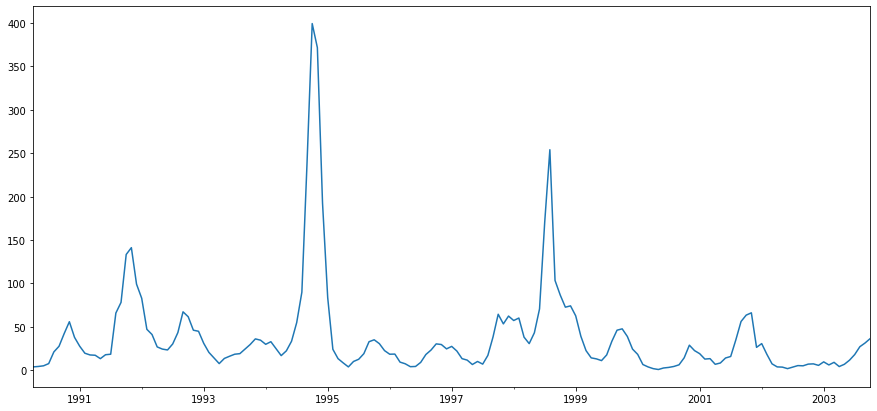

In [18]:
sj_train_train.total_cases.plot();

### First order differencing

In [19]:
sj_train_train_diff = sj_train_train - sj_train_train.shift(1)
sj_train_train_diff = sj_train_train_diff.dropna()

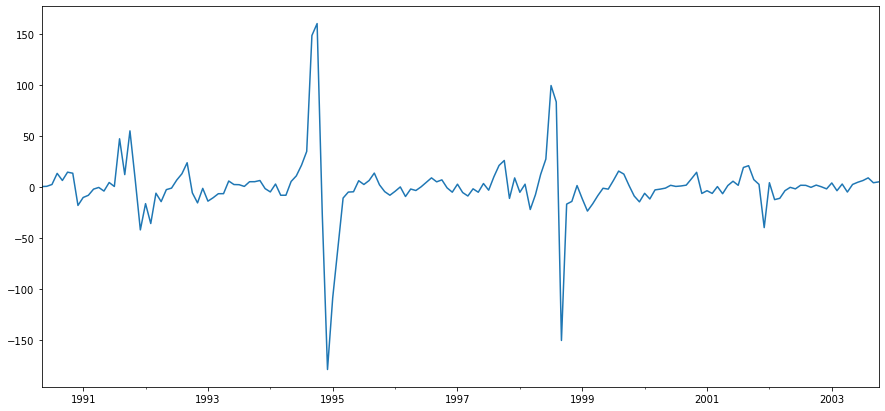

In [20]:
sj_train_train_diff.total_cases.plot();

### ACF

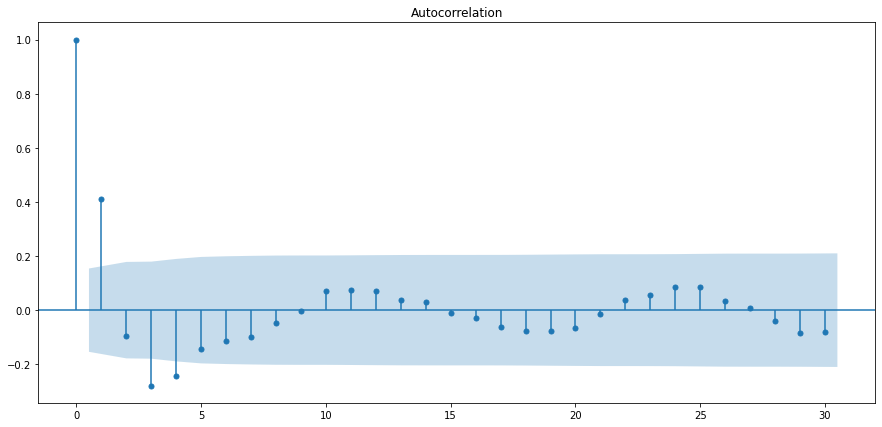

In [21]:
# Check the PACF for the optimal number of lags
plot_acf(sj_train_train_diff.total_cases, lags=30);

### PACF

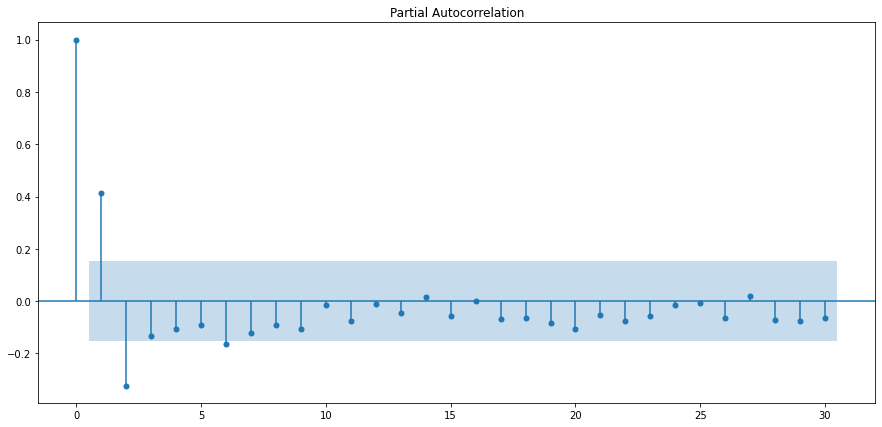

In [22]:
# Check the PACF for the optimal number of lags
plot_pacf(sj_train_train_diff.total_cases, lags=30);

### Fitting the SARIMAX model

In [23]:
corr_mat = sj_train_train.corr()
(
    corr_mat['total_cases']
    .drop(['logged_cases', 'total_cases'], axis=0)
    .abs()
    .sort_values()
)

station_diur_temp_rng_c                  0.013823
ndvi_se                                  0.024813
ndvi_sw                                  0.050774
ndvi_nw                                  0.081758
precipitation_amt_mm                     0.086135
reanalysis_sat_precip_amt_mm             0.086135
reanalysis_tdtr_k                        0.144659
reanalysis_avg_temp_k                    0.152032
reanalysis_air_temp_k                    0.156744
station_precip_mm                        0.157013
station_avg_temp_c                       0.166350
station_min_temp_c                       0.172262
reanalysis_min_air_temp_k                0.175471
reanalysis_precip_amt_kg_per_m2          0.176488
reanalysis_relative_humidity_percent     0.180352
station_max_temp_c                       0.181624
reanalysis_max_air_temp_k                0.183104
reanalysis_dew_point_temp_k              0.184840
reanalysis_specific_humidity_g_per_kg    0.187896
ndvi_ne                                  0.199473


In [24]:
my_exogs = ['reanalysis_tdtr_k',
            'reanalysis_min_air_temp_k',
            'reanalysis_precip_amt_kg_per_m2',
            'reanalysis_relative_humidity_percent',
            'reanalysis_max_air_temp_k',
            'reanalysis_dew_point_temp_k',
            'reanalysis_specific_humidity_g_per_kg',
            'ndvi_ne']

In [25]:
my_order = (2, 1, 4) # Non-seasonal mid1 because differencing with order 1
my_seasonal_order = (1, 0, 1, 12) # Seasonal 12 for 12 months
sarimax_model = SARIMAX(sj_train_train.total_cases, 
                        order=my_order,
                        seasonal_order=my_seasonal_order,
                        exog=sj_train_train[my_exogs])

In [26]:
sarimax_model_fit = sarimax_model.fit()
print(sarimax_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          total_cases   No. Observations:                  163
Model:             SARIMAX(2, 1, 4)x(1, 0, [1], 12)   Log Likelihood                -748.618
Date:                              Wed, 21 Jul 2021   AIC                           1531.235
Time:                                      20:08:25   BIC                           1583.725
Sample:                                  04-01-1990   HQIC                          1552.547
                                       - 10-01-2003                                         
Covariance Type:                                opg                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
reanalysis_tdtr_k                        -3.

/home/mario/neuefische/DenguePred/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [27]:
pred = sarimax_model_fit.forecast(len(sj_train_test.total_cases), exog=sj_train_test[my_exogs])

In [28]:
pred = pd.Series(pred, index=sj_train_test.index)

In [29]:
resid = sj_train_test.total_cases - pred

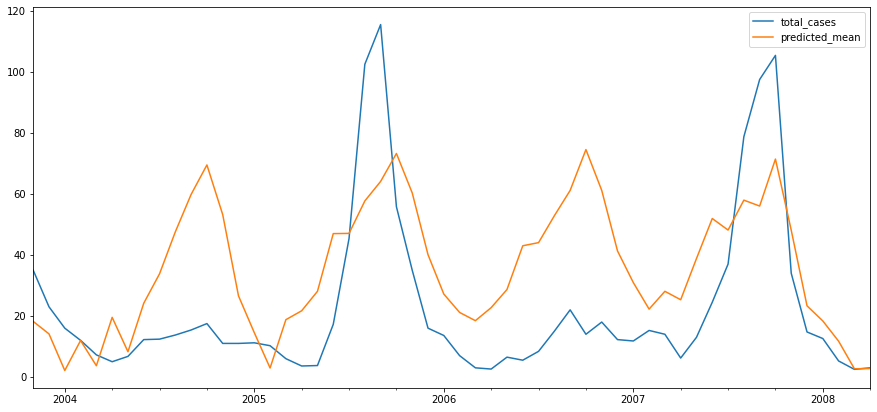

In [30]:
sj_train_test.total_cases.plot(legend=True)
pred.plot(legend=True);

In [31]:
print('RMSE:', np.sqrt(np.mean(resid**2)))

RMSE: 26.22709239804641
